In [ ]:
!python --version
!pip freeze | grep torch

Python 3.6.9
torch==1.7.0+cu101
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101


In [ ]:
# # Import PyDrive and associated libraries.
# # This only needs to be done once in a notebook.
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once in a notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -qq ./drive/My\ Drive/deep_fashion.zip

In [3]:
import csv
import os
import numpy as np
from PIL import Image
import torch

class deep_fashion(torch.utils.data.Dataset):
    def __init__(self, csv_file, mode='train', transform=None):
        
        self.mode = mode # 'train', 'val' or 'test'
        self.data_list = []
        self.labels = []
        self.labels_a = []
        self.transform = transform
        
        with open(csv_file, newline='') as csvfile:
            reader = csv.DictReader(csvfile) # 讀取 CSV 檔內容，將每一列轉成一個 dictionary
            for row in reader:
                self.data_list.append(row['file_path'])
                
                if mode != 'test':
                    self.labels.append(row['category_label'])#attribure 長度為15
                    label_attri=[0 for i in range(15)]
                    a=[np.int(i) for i in row['attribute_label'].split()]
                    for i in a:
                        label_attri[i]=1
                        self.labels_a.append(label_attri)
    def __getitem__(self, index):

        data = Image.open(self.data_list[index])
        if self.transform is not None:
            data = self.transform(data)
        if self.mode == 'test':
            return data
        label = torch.tensor(int(self.labels[index]))
        label_aa = torch.tensor(self.labels_a[index])

        return data, label,label_aa

    def __len__(self):
        return len(self.data_list)
    def data_list(self):
        return (self.data_list)



In [4]:
from torchvision import transforms

transforms_train =transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

transforms_test =transforms.Compose([
  transforms.Resize((224, 224)),
  #transforms.CenterCrop((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


In [5]:
dataset_train = deep_fashion('./deep_fashion/train.csv', mode='train', transform=transforms_train)
dataset_val = deep_fashion('./deep_fashion/val.csv', mode='val', transform=transforms_test)
dataset_test = deep_fashion('./deep_fashion/test.csv', mode='test', transform=transforms_test)

In [6]:
print("The first image's shape in dataset_train :", dataset_train.__getitem__(0)[0].size())
print("There are", dataset_train.__len__(), "images in dataset_train.")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 39092 images in dataset_train.


In [7]:
print("There are", dataset_test.data_list, "images'path in dataset_train.")

There are ['deep_fashion/test/00001.jpg', 'deep_fashion/test/00002.jpg', 'deep_fashion/test/00003.jpg', 'deep_fashion/test/00004.jpg', 'deep_fashion/test/00005.jpg', 'deep_fashion/test/00006.jpg', 'deep_fashion/test/00007.jpg', 'deep_fashion/test/00008.jpg', 'deep_fashion/test/00009.jpg', 'deep_fashion/test/00010.jpg', 'deep_fashion/test/00011.jpg', 'deep_fashion/test/00012.jpg', 'deep_fashion/test/00013.jpg', 'deep_fashion/test/00014.jpg', 'deep_fashion/test/00015.jpg', 'deep_fashion/test/00016.jpg', 'deep_fashion/test/00017.jpg', 'deep_fashion/test/00018.jpg', 'deep_fashion/test/00019.jpg', 'deep_fashion/test/00020.jpg', 'deep_fashion/test/00021.jpg', 'deep_fashion/test/00022.jpg', 'deep_fashion/test/00023.jpg', 'deep_fashion/test/00024.jpg', 'deep_fashion/test/00025.jpg', 'deep_fashion/test/00026.jpg', 'deep_fashion/test/00027.jpg', 'deep_fashion/test/00028.jpg', 'deep_fashion/test/00029.jpg', 'deep_fashion/test/00030.jpg', 'deep_fashion/test/00031.jpg', 'deep_fashion/test/00032.jpg

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=128, shuffle=False)

In [9]:
import torchvision.models as models  
import torch.nn as nn 
import torch.nn.functional as F

class MultiTaskModel(nn.Module):
  def __init__(self):
    super(MultiTaskModel, self).__init__()

  # Loading ResNet arch from PyTorch
    original_model = models.resnext50_32x4d (pretrained=True)
    
    # for param in original_model.parameters():
    #   param.requires_grad = False
      
    # Everything except the last linear layer
    self.features = nn.Sequential(*list(original_model.children())[:-1])
    
    # Get number of features of last layer
    fc_features = original_model.fc.in_features

    self.fc1 =nn.Linear(fc_features, 10)  
    self.fc2 =nn.Linear(fc_features, 15)
    self.fc_model1 = nn.Sequential(			
			#nn.ReLU(),
			nn.Dropout(),
			nn.Linear(fc_features,10))#5為輸出幾類

    self.fc_model = nn.Sequential(			
			#nn.ReLU(),
			nn.Dropout(),
			nn.Linear(fc_features,15))#5為輸出幾類
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)

    out1 = self.fc_model1(x)
    out2 = torch.sigmoid(self.fc2(x))
    # out2= F.log_softmax(out2, dim=1)
    # F.log_softmax(self.l5(x), dim=1)
    return out1, out2


In [10]:
import torch.optim as optim
from torch.optim import lr_scheduler


In [11]:
model=MultiTaskModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


MultiTaskModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [12]:
from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
# train_acc, train_loss = train(train_loader, model, criterion, criterion_a, optimizer)
# input_data=train_loader
criterion, criterion_a=nn.CrossEntropyLoss(),nn.BCELoss()
optimizer =optim.SGD(model.parameters(),lr=0.01, weight_decay= 1e-2,momentum=0.8,nesterov=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [14]:
from sklearn.metrics import f1_score

# x = (torch.rand(4, 4) > 0.5).int().to('cuda')
# y = (torch.rand(4, 4) > 0.5).int().to('cuda')
# f1_score(y.cpu(), x.cpu(), average='samples')


In [15]:
# model.train()
# loss_list =[]
# total_count =total_count_a= 0
# acc_count =acc_count_a= 0
# alpha=0.3
# attri_output=[]
# label_attri=[]
# for data in input_data:
#     images, labels,labels_a = data[0].cuda(), data[1].cuda(), data[2].cuda()

#     optimizer.zero_grad()

#     out,out_a=model(images)#attribute
#     loss_c =criterion(out,labels)
#     loss_a =criterion_a(out_a,labels_a.float())

    
#     loss=loss_c*alpha+(1-alpha)*loss_a

#     loss.backward()
#     scheduler.step()

#     # #class
#     _, predicted =torch.max(out.data,1)#分類會自動套運softmax
#     total_count +=len(labels)
#     acc_count += (predicted==labels).sum().item()
#     loss_list.append(loss.item())

#     #attribute

#     predicted_a=(out_a > 0.5).int().to('cuda')
#     attri_output.append(predicted_a)
#     label_attri.append(labels_a)
# f1_score(label_attri[0].cpu(),attri_output[0].cpu(), average='samples')
# # acc = (acc_count / total_count)
# # loss = sum(loss_list) / len(loss_list)
# attri_output[0]

In [16]:
def train(input_data, model, criterion, criterion_a, optimizer):
    
    model.train()
    loss_list =[]
    attri_output=[]
    label_attri=[]
    total_count =total_count_a= 0
    acc_count =acc_count_a= 0
    alpha=0.3
    for  data in input_data:
        images, labels,labels_a = data[0].cuda(), data[1].cuda(), data[2].cuda()
        
        optimizer.zero_grad()
        out,out_a=model(images)#attribute
        loss_c =criterion(out,labels)
        loss_a =criterion_a(out_a,labels_a.float())

        loss=loss_c*alpha+loss_a*(1-alpha)

        loss.backward()
        optimizer.step()

        #class
        _, predicted =torch.max(out.data,1)#分類會自動套運softmax
        total_count +=len(labels)
        acc_count += (predicted==labels).sum().item()
        loss_list.append(loss.item())

        #attribute
        predicted_a=(out_a > 0.0667).int().to('cuda')
        attri_output.append(predicted_a)
        label_attri.append(labels_a)

    f1=f1_score(label_attri[0].cpu(),attri_output[0].cpu(), average='samples')  

    acc = (acc_count / total_count)
    loss = sum(loss_list) / len(loss_list)
    return acc, loss,f1

In [17]:
def val(input_data, model, criterion, criterion_a):
    model.eval()

    loss_list =[]
    attri_output=[]
    label_attri=[]
    total_count =total_count_a= 0
    acc_count =acc_count_a= 0
    alpha=0.3
    with torch.no_grad():
        for data in input_data:
            images, labels,labels_a = data[0].cuda(), data[1].cuda(), data[2].cuda()

            out,out_a=model(images)#attribute
            loss_c =criterion(out,labels)
            loss_a =criterion_a(out_a,labels_a.float())

            loss=loss_c*alpha+loss_a*(1-alpha)

            #class
            _, predicted =torch.max(out.data,1)#分類會自動套運softmax
            total_count +=len(labels)
            acc_count += (predicted==labels).sum().item()
            loss_list.append(loss.item())

            #attribute
            predicted_a=(out_a > 0.0667).int().to('cuda')
            attri_output.append(predicted_a)
            label_attri.append(labels_a)
    f1=f1_score(label_attri[0].cpu(),attri_output[0].cpu(), average='samples')
    acc = (acc_count / total_count)
    loss = sum(loss_list) / len(loss_list)
    return acc, loss,f1

In [18]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [ ]:
max_epochs =20
log_interval = 2 # print acc and loss in per log_interval time
################################################################################
#                               End of your code                               #
################################################################################
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []
train_f1_list = []
val_f1_list = []
early_stopping = EarlyStopping(patience=5, verbose=True)


for epoch in range(1, max_epochs + 1):

    train_acc, train_loss,f1_train = train(train_loader, model, criterion, criterion_a, optimizer)
    val_acc, val_loss,f1_val = val(val_loader, model, criterion, criterion_a)
    scheduler.step()

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_f1_list.append(f1_train)
    val_f1_list.append(f1_val)

    if epoch % log_interval == 0:
        print('=' * 20, 'Epoch', epoch, '=' * 20)
        print('Train Acc: {:.6f} Train Loss: {:.6f} f1_score: {:.6f}'.format(train_acc, train_loss,f1_train))
        print('Val Acc: {:.6f}   Val Loss: {:.6f} f1_score: {:.6f}'.format(val_acc, val_loss,f1_val))
    
    early_stopping(val_loss, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    output_list_a = []
    with torch.no_grad():
        for data in input_data:
            images = data.cuda()
            outputs,outputs_a = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_a=(outputs_a>0.5)
            output_list.extend(predicted.to('cpu').numpy().tolist())
            output_list_a.extend(predicted_a.to('cpu').numpy().tolist())

    return output_list,output_list_a



In [ ]:
output_csv = predict(test_loader, model)


In [ ]:
total=[]
for row in range(len(output_csv[1])):
  attribute=[]

  for i in range(15):
    if output_csv[1][row][i]==True:
      attribute.append(str(i))
  
  attri=" ".join(attribute)
  total.append(attri)
total

In [ ]:
with open('category_label_f1.csv', 'w', newline='') as csvFile:

    writer = csv.DictWriter(csvFile, fieldnames=['file_path', 'category_label'])
    writer.writeheader()
    for path,result in zip(dataset_test.data_list,output_csv[0] ):
        writer.writerow({'file_path':path, 'category_label':result})

# # Create & upload a text file.
# category_label = drive.CreateFile({'title': 'category_label_resnet1.csv'})
# category_label.SetContentFile('category_label_f1.csv')
# category_label.Upload()
# print('Uploaded file with ID {}'.format(category_label.get('id')))

In [ ]:
with open('attribute_label_f1.csv', 'w', newline='') as csvFile_a:

    writer_a = csv.DictWriter(csvFile_a, fieldnames=['file_path', 'attribute_label'])
    writer_a.writeheader()
    for path,attribute in zip(dataset_test.data_list,total):
        writer_a.writerow({'file_path':path, 'attribute_label':attribute})

# # Create & upload a text file.
# attribute_label = drive.CreateFile({'title': 'attribute_label_resnet50.csv'})
# attribute_label.SetContentFile('attribute_label_f1.csv')
# attribute_label.Upload()
# print('Uploaded file with ID {}'.format(attribute_label.get('id')))

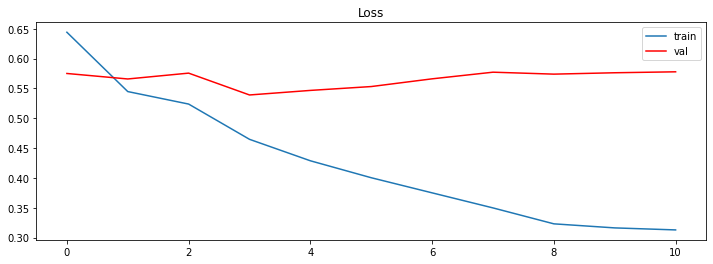

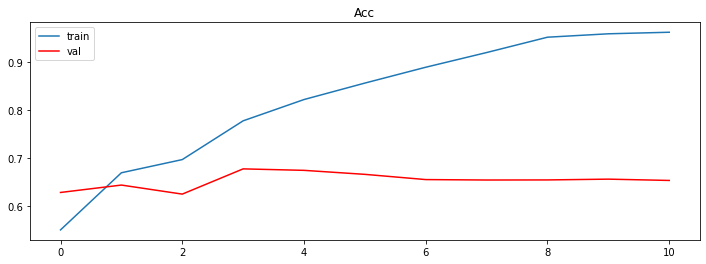

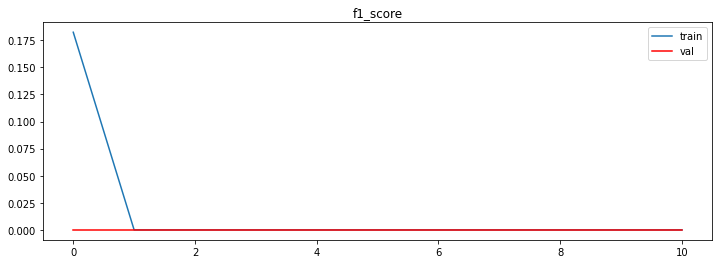

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_loss_list)), train_loss_list)
plt.plot(range(len(val_loss_list)), val_loss_list, c='r')
plt.legend(['train', 'val'])
plt.title('Loss')

plt.show()
plt.figure(figsize=(12, 4))
plt.plot(range(len(train_acc_list)), train_acc_list)
plt.plot(range(len(val_acc_list)), val_acc_list, c='r')
plt.legend(['train', 'val'])
plt.title('Acc')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(range(len(train_f1_list)), train_f1_list)
plt.plot(range(len(val_f1_list)), val_f1_list, c='r')
plt.legend(['train', 'val'])
plt.title('f1_score')
plt.show()